In [3]:
!pip install pymatgen -q

In [15]:
from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

import sys
sys.path.append('..')
from src.band_plotters import *


from resnet_autoencoder import model

## Load

In [16]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

In [26]:
class PILImageNoised(PILImage): pass
class TensorImageNoised(TensorImage): pass
PILImageNoised._tensor_cls = TensorImageNoised

class AddNoiseTransform(Transform):
    "Add noise to image"
    split_idx=0
    order = 11
    def __init__(self, noise_factor=0.3): self.noise_factor = noise_factor
    def encodes(self, o:TensorImageNoised): return o + (self.noise_factor * torch.randn(*o.shape).to(o.device))

class RandomErasingTransform(RandTransform):
    "Randomly selects a rectangle region in an image and randomizes its pixels."
    order = 100 # After Normalize
    def __init__(self, 
        p:float=0.5, # Probability of appying Random Erasing
        sl:float=0., # Minimum proportion of erased area
        sh:float=0.3, # Maximum proportion of erased area
        min_aspect:float=0.3, # Minimum aspect ratio of erased area
        max_count:int=1 # Maximum number of erasing blocks per image, area per box is scaled by count
    ):
        store_attr()
        super().__init__(p=p)
        self.log_ratio = (math.log(min_aspect), math.log(1/min_aspect))

    def _bounds(self, area, img_h, img_w):
        r_area = random.uniform(self.sl,self.sh) * area
        aspect = math.exp(random.uniform(*self.log_ratio))
        return self._slice(r_area*aspect, img_h) + self._slice(r_area/aspect, img_w)
    
    def _slice(self, area, sz):
        bound = int(round(math.sqrt(area)))
        loc = random.randint(0, max(sz-bound, 0))
        return loc,loc+bound
    def cutout_gaussian(self,
                        
        x:TensorImageNoised, # Input image 
        areas:list # List of areas to cutout. Order rl,rh,cl,ch
    ):
        "Replace all `areas` in `x` with N(0,1) noise"
        chan,img_h,img_w = x.shape[-3:]
        for rl,rh,cl,ch in areas: x[..., rl:rh, cl:ch].normal_()
        return x

    def encodes(self,x:TensorImageNoised):
        count = random.randint(1, self.max_count)
        _,img_h,img_w = x.shape[-3:]
        area = img_h*img_w/count
        areas = [self._bounds(area, img_h, img_w) for _ in range(count)]
        return self.cutout_gaussian(x, areas)

torch.Size([32, 3, 128, 128])

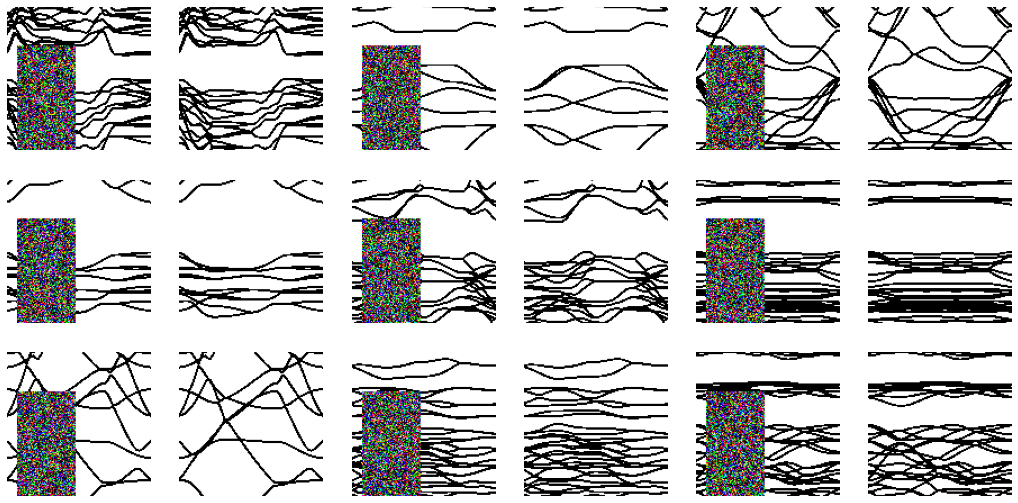

In [27]:
IMAGE_SIZE = 128
#Z_DIM = IMAGE_SIZE / 32 * Z_CHANNELS

dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageNoised), ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((IMAGE_SIZE))],
    batch_tfms=[Binarize(), RandomErasingTransform()]
        ).dataloaders(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3", bs=32)

dls.show_batch()

xb, yb = dls.one_batch()
xb.shape

## Train

### Create Learner

In [28]:
def kld_mean_loss(mu, logvar):
    return torch.mean(-0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

In [29]:
def log_cosh_loss(pred, targ, a):
    loss = (1/a) * torch.log(torch.cosh(a*(pred-targ)))
    
    return loss.mean()

def mse_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return 3.3*F.mse_loss(x_recon, targ) + 0.05 * kld_mean_loss(mu, logvar)

def bce_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return nn.BCEWithLogitsLoss()(x_recon, targ) + 0.05 * kld_mean_loss(mu, logvar)

def mse_recon_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return F.mse_loss(x_recon, targ)

# loss = partial(log_cosh_loss, a=0.55)

In [30]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new
    return model

In [31]:
class BiasLayer(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        bias_value = torch.randn((1))
        self.bias_layer = torch.nn.Parameter(bias_value)
    
    def forward(self, x):
        return x + self.bias_layer

In [41]:
class ResidualLayer(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, 1)
    def forward(self, x):
        return x + self.conv(x)

In [56]:
# for arch in ["resnet18"]:

loss = bce_loss
sigmoid = True
if loss == bce_loss:
    sigmoid = False
Z_CHANNELS = 5
# Z_DIM = 128

ae = model.ResnetVAE(configs=[2, 2, 2, 2], bottleneck=False, sigmoid=sigmoid, z_channels=Z_CHANNELS)
list(ae.encoder.conv5.children())[1].relu = nn.Sequential(nn.ReLU(), ResidualLayer(Z_CHANNELS*2)) #BiasLayer())#)
# ae = convert_act_cls(ae, "ReLU", "LeakyReLU")

# ae = model.ResnetVae("resnet18", sigmoid=sigmoid, z_channels=Z_CHANNELS)
# ae = model.ResNetAutoEncoderCompressed([2, 2, 2, 2], False, 64)

learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback()])



epoch,train_loss,valid_loss,time
0,0.595061,0.573560,00:12
1,0.529059,0.523905,00:12
2,0.507597,0.502497,00:12
3,0.493331,0.505617,00:12
4,0.480060,0.479699,00:12
5,0.471227,0.469886,00:12
6,0.463741,0.462989,00:12
7,0.459414,0.456966,00:12
8,0.454236,0.448529,00:12
9,0.449721,0.458976,00:12


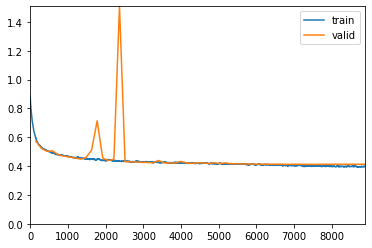

In [57]:
learn.fit_one_cycle(60)

## Save and Load Learner

In [62]:
# learn.export(f"trained_models/vae_resnet18_size128_lossbcekl_randerase_channels{Z_CHANNELS}.pkl")
# learn = load_learner("trained_models/vae_resnet18_size128_lossbcekl_randerase_channels6.pkl")
# out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-1.png")
# show_image(out[1])

## View Predictions

In [63]:
from ipywidgets import interact

def show(i):
    train=False
    if train:
        xb, yb = dls.train.one_batch()
    else:
        xb, yb = dls.valid.one_batch()
        
    learn.cuda()
    
    mu = learn.model(xb)[1]
    inp = mu.view(mu.shape[0], Z_CHANNELS, 4, 4)
    preds = learn.model.decoder(inp)
    
    show_image(xb[i])
    if sigmoid:
        show_image(preds[i])
    else:
        show_image(torch.sigmoid(preds[i]))
        
    if train:
        show_image(yb[i])
    # print(len(preds))
    
    # print(learn.model.encoder(xb.cuda()).shape)

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>

In [ ]:
xb, yb = dls.valid.one_batch()
learn.cuda()

mu = learn.model(xb)[1]

In [157]:
from ipywidgets import interact

def show_w_draw(i):
    xb, yb = dls.valid.one_batch()
    learn.cuda()
    preds = learn.model(xb)
    show_image(xb[i])
    
    if sigmoid:
        pred = preds[0][i]
    else:
        pred = torch.sigmoid(preds[0][i])
        

    show_image(pred)
    

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>